# Load, Clean, and Preliminary EDA Housing Data

## Imports

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from clean_data import get_nearly_empty_columns, trim_outliers
from engineer_features import or_merge, get_seasons

## Load Data

The Python script `modules/load_data.py` was used to load housing data from the JSON files in `data/raw`, generate a DataFrame, and export the DataFrame to a CSV file, `data/processed/housing_data_0.csv`. The script loops through all JSON files, parsing them for information concerning a house's sale price, sale date, description, location, tags, and flags.

Get started by loading `data/processed/housing_data_0.csv`.

In [2]:
dirname = '../data/processed/'
basename = 'housing_data_0.csv'
filename = dirname + basename
df = pd.read_csv(filename, sep=',')
df.shape

/tmp/ipykernel_2515873/1944719485.py:4: DtypeWarning: Columns (191,192) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep=',')


(8159, 193)

## Clean Data

The loaded housing DataFrame contains a lot of columns, many of which are filled with missing information. Some of the columns are irrelevant or redundant, and some rows are missing a sale price. In this section, we formulate and implement data cleaning steps.

### Identify Nearly-Empty Columns

In [3]:
cols_to_drop = []  # a running list of columns to drop

We identify columns that are at least 95% empty and flag them to be dropped.

In [4]:
cols_to_drop.extend(get_nearly_empty_columns(df))

### Identify Irrelevant/Redundant Columns

We identify columns that are likely irrelevant to the sale price of a house and flag them to be dropped.

In [5]:
cols_to_drop.extend(['list_date', 'property_id', 'listing_id'])

There are several columns that contain redundant information. In the following, we identify them and flag them to be dropped.

In [6]:
print(df['status'].nunique())
cols_to_drop.append('status')

1


In [7]:
print(df['is_new_listing'].fillna(False).nunique())
cols_to_drop.append('is_new_listing')

1


In [8]:
cols = ['baths_3qtr', 'baths_full', 'baths_half', 'baths', 'ensuite'] 
print(df[cols].sample(5))

cols_to_drop.extend(['baths_3qtr', 'baths_full', 'baths_half'])

      baths_3qtr  baths_full  baths_half  baths ensuite
3011         NaN         3.0         NaN    3.0     NaN
4840         1.0         1.0         NaN    2.0     NaN
2724         NaN         2.0         NaN    2.0     NaN
549          NaN         2.0         1.0    3.0     NaN
451          1.0         1.0         NaN    2.0     NaN


In [9]:
cols = ['garage', 'garage_1_or_more', 'garage_2_or_more', 'garage_3_or_more', 'carport']
print(df[cols].sample(5))

cols_to_drop.extend(['garage_1_or_more', 'garage_2_or_more', 'garage_3_or_more'])

      garage garage_1_or_more garage_2_or_more garage_3_or_more carport
5265     NaN              NaN              NaN              NaN     NaN
4618     2.0             True             True              NaN     NaN
614      NaN              NaN              NaN              NaN     NaN
2464     NaN              NaN              NaN              NaN     NaN
2360     NaN              NaN              NaN              NaN     NaN


In [10]:
cols = ['stories', 'single_story', 'two_or_more_stories']
print(df[cols].sample(5))

cols_to_drop.extend(['single_story', 'two_or_more_stories'])

      stories single_story two_or_more_stories
1054      NaN          NaN                 NaN
6953      1.0         True                 NaN
4006      2.0          NaN                True
3881      NaN          NaN                 NaN
356       2.0          NaN                True


In [11]:
cols = ['type', 'sub_type']
print(df[cols].sample(5))

cols_to_drop.append('sub_type')

               type sub_type
6312         condos    condo
1403  single_family      NaN
726   single_family      NaN
7727  single_family      NaN
4210  single_family      NaN


In [12]:
cols = ['price_reduced_amount', 'is_price_reduced']
print(df[cols].sample(5))

cols_to_drop.append('is_price_reduced')

      price_reduced_amount is_price_reduced
646                    NaN              NaN
7040                   NaN              NaN
1455                4000.0            False
2042                   NaN              NaN
137                    NaN              NaN


We consider geographical data.

In [13]:
cols = ['city', 'state', 'postal_code', 'lat', 'lon']
df[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   city         8154 non-null   object 
 1   state        8159 non-null   object 
 2   postal_code  8159 non-null   int64  
 3   lat          7909 non-null   float64
 4   lon          7909 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 318.8+ KB


We keep the `city`, `state` and `postal_code` columns. 

In [14]:
cols_to_drop.extend(['lat', 'lon'])

In [15]:
cols = [
    'views', 'view', 'hill_or_mountain_view', 'city_view',
    'big_yard', 'big_lot', 'fenced_yard', 'front_porch',
    'groundscare', 'farm', 'ranch', 
]
print(df[cols].fillna(False).sample(5))

cols_to_drop.extend([
    'views', 'hill_or_mountain_view', 
    'city_view', 'big_yard', 'big_lot'
])

      views   view  hill_or_mountain_view  city_view  big_yard  big_lot  \
6740  False  False                  False      False      True    False   
4940  False  False                  False      False     False    False   
381   False  False                  False      False     False     True   
6928  False  False                  False      False      True    False   
2667  False   True                   True      False     False    False   

      fenced_yard  front_porch  groundscare   farm  ranch  
6740         True        False        False   True   True  
4940        False        False        False  False  False  
381         False        False        False  False  False  
6928         True        False        False   True   True  
2667        False        False        False  False  False  


### Drop Irrelevant/Redundant Columns

In [16]:
df = df.drop(columns=cols_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price_reduced_amount         2484 non-null   float64
 1   year_built                   7316 non-null   float64
 2   sold_date                    8159 non-null   object 
 3   sold_price                   6716 non-null   float64
 4   lot_sqft                     6991 non-null   float64
 5   sqft                         7323 non-null   float64
 6   baths                        7980 non-null   float64
 7   garage                       4448 non-null   float64
 8   stories                      6260 non-null   float64
 9   beds                         7504 non-null   float64
 10  type                         8125 non-null   object 
 11  postal_code                  8159 non-null   int64  
 12  state                        8159 non-null   object 
 13  city              

### Identify Rows Without Sale Price

There are rows that are missing a sale price. As house sale price will serve as the target in the upcoming machine learning analysis, we drop the rows in question.

In [17]:
filter = df['sold_price'].isna()
rows_to_drop = df.loc[filter, :].index.to_list()

### Drop Rows Without Sale Price

In [18]:
df = df.drop(index=rows_to_drop)

### Identify Appropriate Imputation Methods

Most columns are missing values. For each, we identify the most appropriate method for filling in the missing values.

The following columns should be imputed with `0`:

In [19]:
na_to_zero = ['price_reduced_amount', 'garage']

The following columns shoud be imputed with `False`:

In [20]:
columns_list = df.columns.to_list()
central_air_idx = columns_list.index('central_air')
na_to_false = columns_list[central_air_idx:]
na_to_false

['central_air',
 'central_heat',
 'fireplace',
 'rental_property',
 'community_outdoor_space',
 'energy_efficient',
 'community_security_features',
 'recreation_facilities',
 'carport',
 'dishwasher',
 'washer_dryer',
 'laundry_room',
 'floor_plan',
 'ensuite',
 'shopping',
 'hardwood_floors',
 'high_ceiling',
 'community_swimming_pool',
 'modern_kitchen',
 'open_floor_plan',
 'fenced_yard',
 'new_roof',
 'front_porch',
 'groundscare',
 'basement',
 'updated_kitchen',
 'corner_lot',
 'farm',
 'park',
 'ranch',
 'trails',
 'forced_air',
 'dining_room',
 'family_room',
 'view']

The following columns should be imputed with median values:

In [21]:
na_to_median = ['lot_sqft', 'sqft']

The following columns should be imputed with modes:

In [22]:
na_to_mode = ['year_built', 'baths', 'stories', 'beds', 'type']

The following columns should be imputed with a city:

In [23]:
na_to_city = ['city']

In [24]:
df[df['city'].isna()][['city', 'state', 'postal_code']]

,city,state,postal_code
391,NaN,Ohio,43235
3045,NaN,Ohio,43235
4779,NaN,Ohio,43235
6107,NaN,Ohio,43235
7148,NaN,Ohio,43235


There are only five rows missing a city. They all have the same postal code, 43235. This postal code serves Columbus, OH. (Note that, if cities corresponding to many postal codes were missing, it would be worth using an API to fill in the missing values. But, for one missing city, this would be way too much work.)

### Implement Imputations

In [25]:
for c in na_to_zero:
    df[c] = df[c].fillna(0)

for c in na_to_false:
    df[c] = df[c].fillna(False)

for c in na_to_median:
    df[c] = df[c].fillna(df[c].median())

for c in na_to_mode:
    df[c] = df[c].fillna(df[c].mode()[0])

for c in na_to_city:
    df[c] = df[c].fillna('Columbus')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6716 entries, 0 to 8158
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price_reduced_amount         6716 non-null   float64
 1   year_built                   6716 non-null   float64
 2   sold_date                    6716 non-null   object 
 3   sold_price                   6716 non-null   float64
 4   lot_sqft                     6716 non-null   float64
 5   sqft                         6716 non-null   float64
 6   baths                        6716 non-null   float64
 7   garage                       6716 non-null   float64
 8   stories                      6716 non-null   float64
 9   beds                         6716 non-null   float64
 10  type                         6716 non-null   object 
 11  postal_code                  6716 non-null   int64  
 12  state                        6716 non-null   object 
 13  city                   

### Identify Structural Errors

In [26]:
df['type'].value_counts()

type
single_family                  4534
condos                          656
townhomes                       486
multi_family                    486
land                            316
mobile                          146
condo                            52
apartment                        20
other                            10
duplex_triplex                    5
condo_townhome_rowhome_coop       5
Name: count, dtype: int64

There are a few replacements we make to this column of categorical data, merging some categories.

In [27]:
to_replace = {
    'condos': 'condo',
    'townhomes': 'townhome',
    'apartment': 'condo',
    'duplex_triplex': 'other',
    'condo_townhome_rowhome_coop': 'other'
}

### Implement Structural Error Fixes

In [28]:
df['type'] = df['type'].replace(to_replace=to_replace)

### Identify Suitable dtypes

There are a few columns whose dtypes should be updated.

In [29]:
to_int_cols = ['year_built', 'baths', 'garage', 'stories', 'beds']
to_category_cols = 'type'
to_date_cols = 'sold_date'

### Implement dtype Changes

In [30]:
df[to_int_cols] = df[to_int_cols].astype('int')
df[to_category_cols] = df[to_category_cols].astype('category')
df[to_date_cols] = pd.to_datetime(df[to_date_cols], format='%Y-%m-%d')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6716 entries, 0 to 8158
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   price_reduced_amount         6716 non-null   float64       
 1   year_built                   6716 non-null   int64         
 2   sold_date                    6716 non-null   datetime64[ns]
 3   sold_price                   6716 non-null   float64       
 4   lot_sqft                     6716 non-null   float64       
 5   sqft                         6716 non-null   float64       
 6   baths                        6716 non-null   int64         
 7   garage                       6716 non-null   int64         
 8   stories                      6716 non-null   int64         
 9   beds                         6716 non-null   int64         
 10  type                         6716 non-null   category      
 11  postal_code                  6716 non-null   int

### Export Cleaned Data

Prior to engineering features and/or trimming outliers, we export the DataFrame.

In [32]:
dirname = '../data/processed/'
basename = 'housing_data_1_new.csv'
filename = dirname + basename
df.to_csv(filename, sep=',', header=True, index=False)

## Engineering Features

### Merge Existing Features

There are a few collections of features that perhaps make most sense merged (using 'or') into a combined feature.

In [33]:
df = df\
    .pipe(or_merge, 
          ['community_outdoor_space', 'park', 'trails'], 
          'near_outdoors')\
    .pipe(or_merge, 
          ['recreation_facilities', 'community_swimming_pool'], 
          'near_rec_facilities')\
    .pipe(or_merge, 
          ['updated_kitchen', 'modern_kitchen'], 
          'fancy_kitchen')

### Add New Features

Conventional wisdom suggest that houses are more expensive in the summer than in the winter. As such, we add a 'season' feature generated from the 'sold_date' feature.

In [34]:
df['season'] = get_seasons(df['sold_date']).astype('category')

**Another feature that we really must add is some form of sold-price central value by geographical region. We choose to add a median-sold-price-by-postal-code feature. However, to prevent data leakage, this feature will need to be added later on, after the train-test split.** 

### Encode Boolean and Categorical Features

There are two categorical features, type and season, and many Boolean features. These need to be converted to numbers for a macine-learning analysis. We'll one-hot encode the categorical features and let True -> 1 and False -> 0 in the Boolean features.

In [35]:
categorical_features = ['type', 'season']
df = pd.get_dummies(df, columns=categorical_features)

to_replace = {
    True: 1,
    False: 0
}

df = df.replace(to_replace=to_replace)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6716 entries, 0 to 8158
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   price_reduced_amount         6716 non-null   float64       
 1   year_built                   6716 non-null   int64         
 2   sold_date                    6716 non-null   datetime64[ns]
 3   sold_price                   6716 non-null   float64       
 4   lot_sqft                     6716 non-null   float64       
 5   sqft                         6716 non-null   float64       
 6   baths                        6716 non-null   int64         
 7   garage                       6716 non-null   int64         
 8   stories                      6716 non-null   int64         
 9   beds                         6716 non-null   int64         
 10  postal_code                  6716 non-null   int64         
 11  state                        6716 non-null   obj

## Export Cleaned Data

Prior to train-test splitting and feature engineering, we export this clean version of the housing data.

In [37]:
dirname = '../data/processed/'
basename = 'housing_data_2_untrimmed.csv'
filename = dirname + basename
df.to_csv(filename, sep=',', header=True, index=False)

## EDA Visualizations

### Box Plots and Histograms

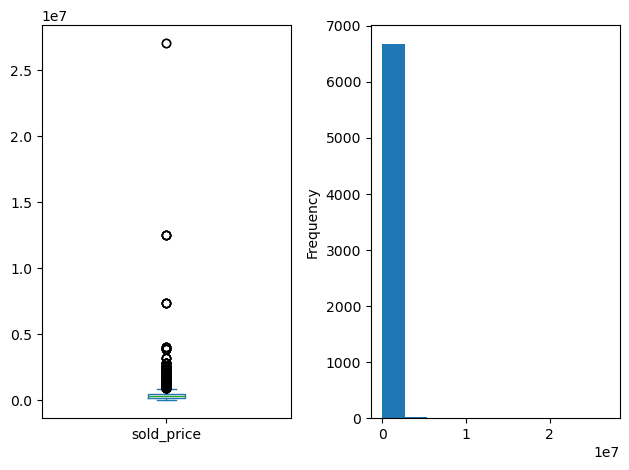

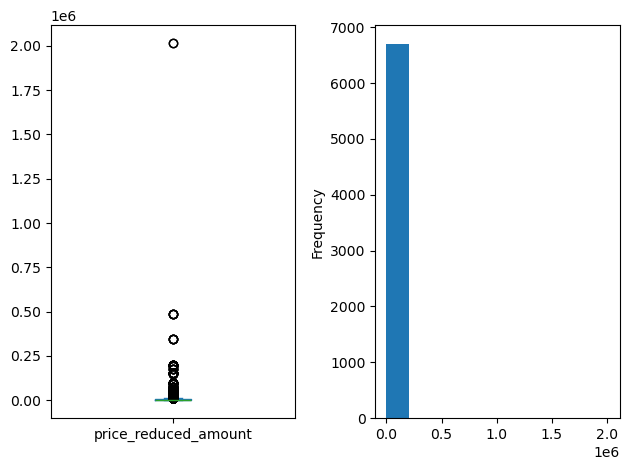

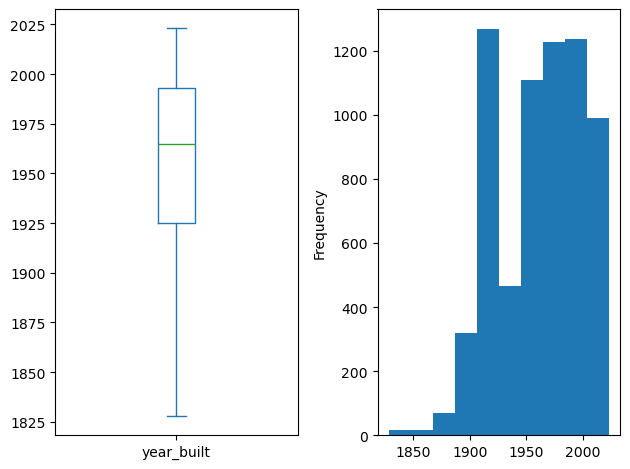

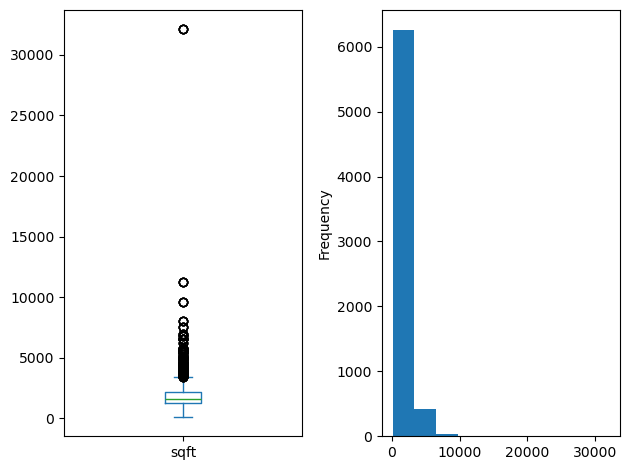

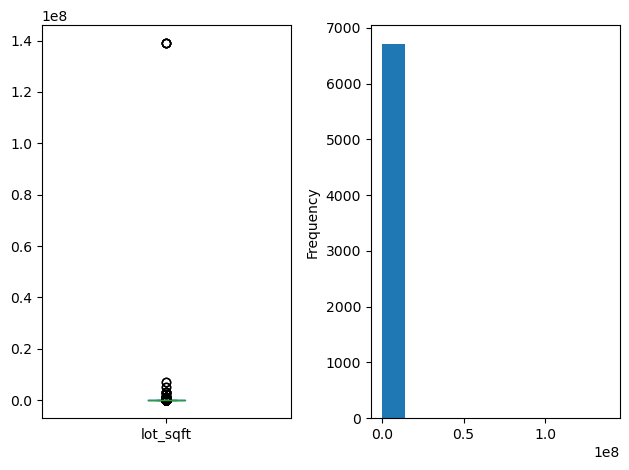

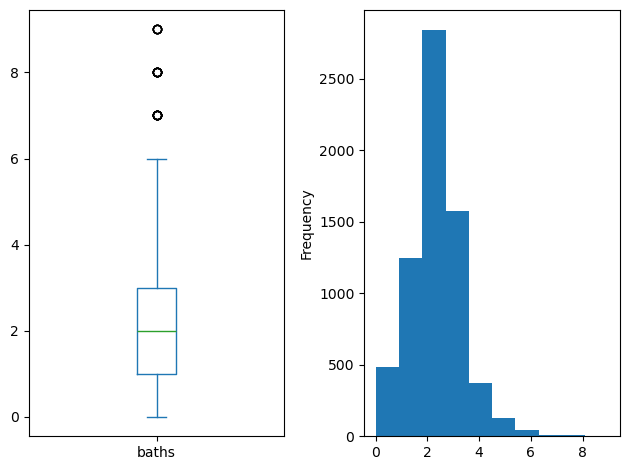

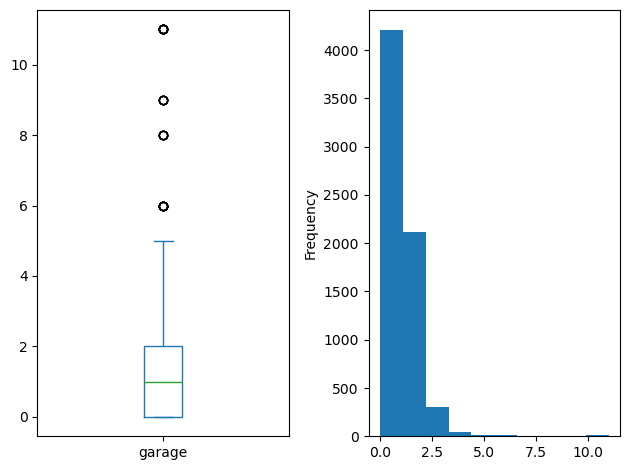

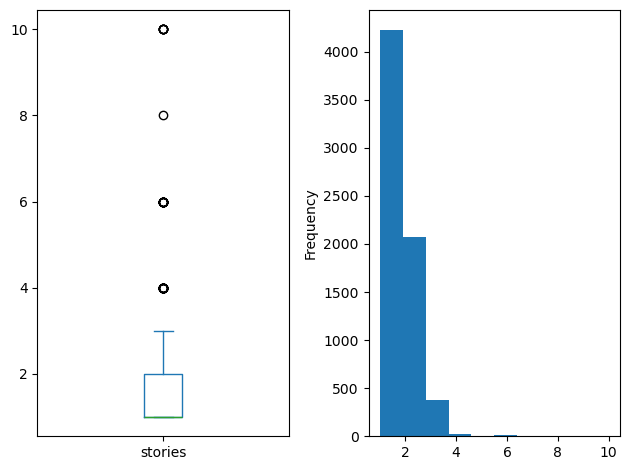

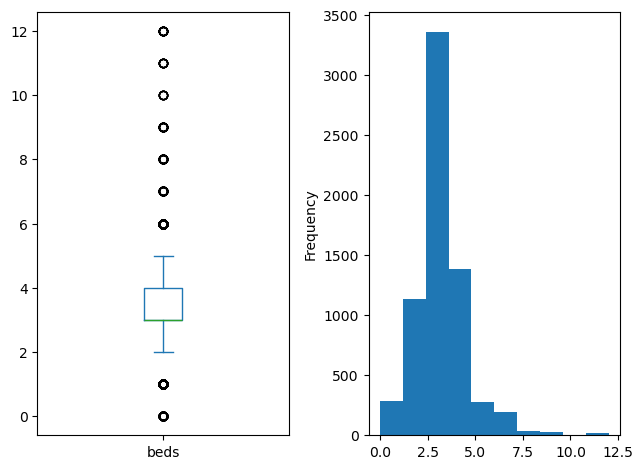

In [51]:
numeric_features = [
    'sold_price', 'price_reduced_amount', 'year_built', 'sqft',
    'lot_sqft', 'baths', 'garage', 'stories', 'beds'
]

for feature in numeric_features:
    ser = df[feature]
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ser.plot(kind='box', ax=ax[0])
    ser.plot(kind='hist', ax=ax[1])
    fig.tight_layout()

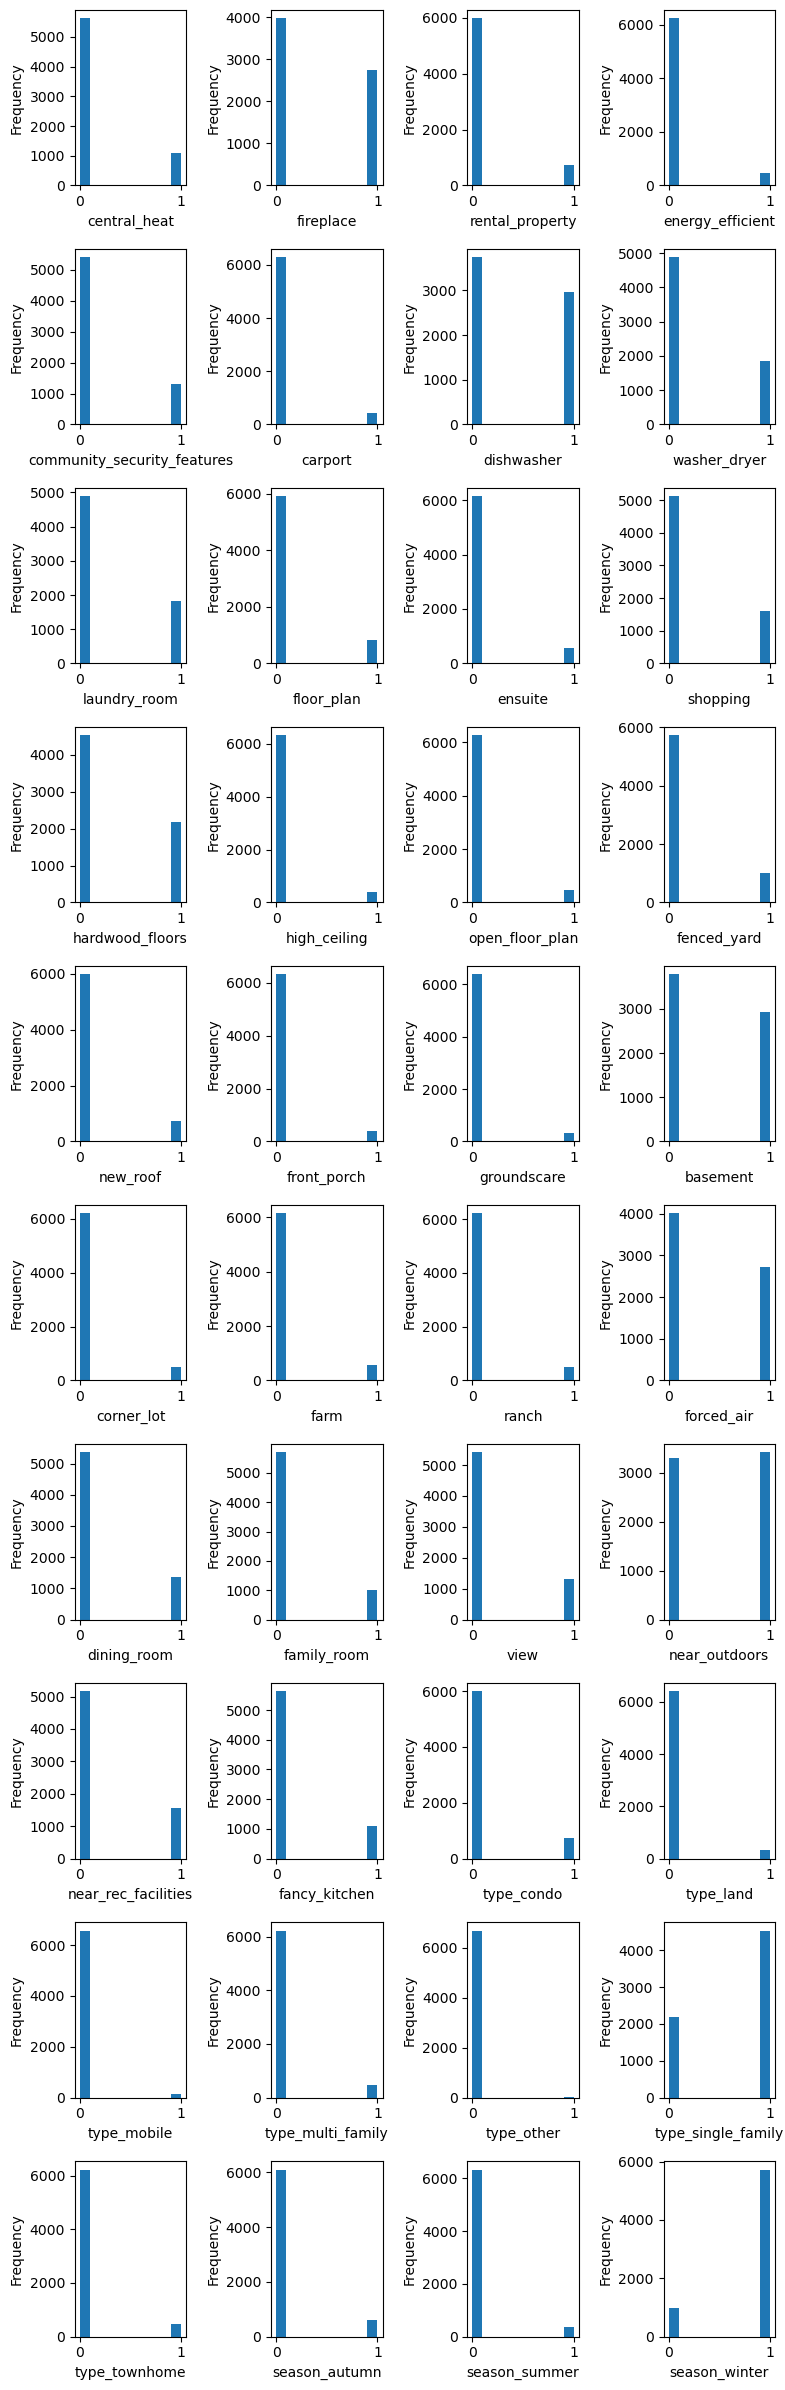

In [52]:
boolean_features = df.columns.to_list()[central_air_idx:]
nrows, ncols = 10, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 24))
num_bools = len(boolean_features)
for col in range(num_bools):
    r = col // ncols
    c = col % ncols
    df[boolean_features[col]].plot(
        kind='hist', 
        ax=axes[r, c], 
        xlabel=boolean_features[col]
    )
fig.tight_layout()

### Trim Outliers

As we can see from the above box-and-whisker plots, certain features have a lot of outliers. To deal with them, we use the IQR method to trim outliers from sold_price as well as those features which have a significant correlation with sold_price. Choosing those features has been an iterative process, and corresponding correlation matrix heat maps are shown later on. 

In [61]:
significant_features = [
    'sold_price', 'sqft', 'baths', 'garage', 'beds', 'year_built'
]

df = trim_outliers(df, significant_features)

### Update Histograms

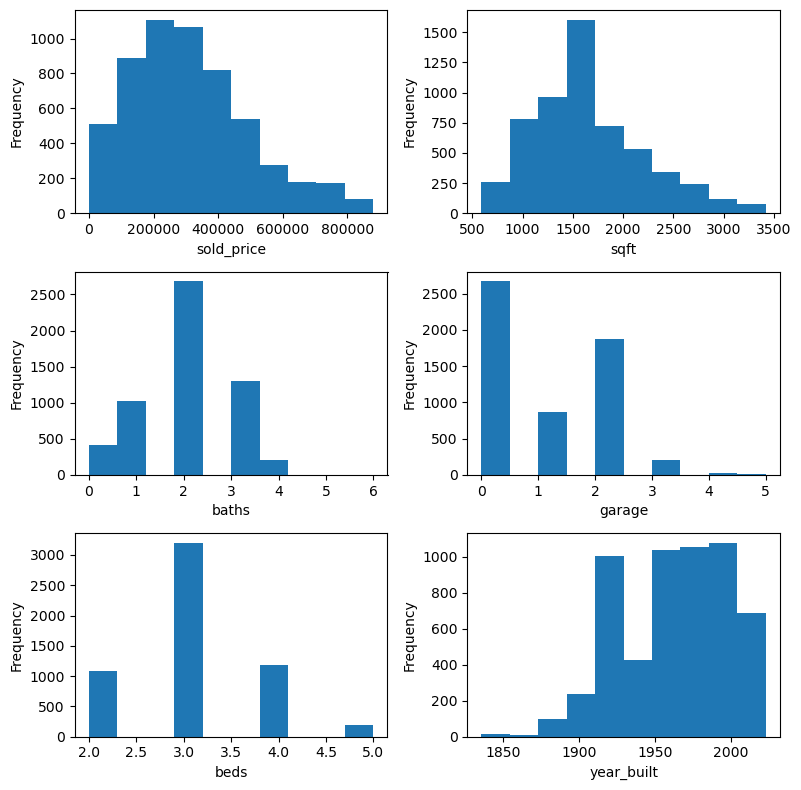

In [62]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
for sf in significant_features:
    sf_idx = significant_features.index(sf)
    row = sf_idx // ncols
    col = sf_idx % ncols
    df[sf].plot(kind='hist', ax=axes[row, col], xlabel=sf)
fig.tight_layout()

## Export Trimmed Data

In [63]:
dirname = '../data/processed/'
basename = 'housing_data_2_trimmed.csv'
filename = dirname + basename
df.to_csv(filename, sep=',', header=True, index=False)

## Train-Test Split

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

In [38]:
# OHE categorical variables here
# tags will have to be done manually

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE such as using central tendency?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- If you replace cities or states with numerical values, make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Drop columns that aren't needed.
- Don't keep the list price because it will be too close to the sale price.

In [39]:
# perform train test split here
# do something with state and city
# drop any other not needed columns

**STRETCH**

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [40]:
# import, join and preprocess new data here

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

In [41]:
# perform EDA here

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized